Dhananjay Tiwari,
Ph.D. Mechanical Engineering,
Mechanical Engineering Laboratory, 1204
University of Illinois at Urbana Champaign

This file has the code for implementation of FLPO optimization problem using using scipy optimizers

In [11]:
# include libraries and dependencies
import numpy as np # Computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots
from scipy import optimize # optimization module in scipy
from scipy.optimize import minimize # minimize function using various algorithms
from scipy.optimize import Bounds # to define bounds on decision variables
from scipy.optimize import LinearConstraint # to define linear constraints on decision variables
import time

In [12]:
# create FLPO class and define its associated functions
class FLPO():

    # define data members of the class
    N : int # number of vehicles
    M : int # number of nodes
    K : int # number of stages
    uav_id : list # vehicle indices
    node_id : list # facility indices
    stop_id : list # destination id
    Adj_mat : np.ndarray # adjacency matrix of the nodes
    uav_init : list # list of initial nodes of all the uavs
    uav_stop : list # list of stop nodes of all the uavs
    node_param : dict # node parameters
    num_param : dict # number of parameters
    node_lcn : np.ndarray # array of node locations
    speed_lim : np.ndarray # array of minimum and maximum speed limits of vehicles
    beta : float # annealing parameter

    dt_min : list # list of matrices of the minimum time taken to travel along the paths by all the vehicles
    dt_max : list # list of matrices of the maximum time taken to travel along the paths by all the vehicles

    stages : list # FLPO stages, K elements
                  #   Nx1  (M+1)x1  (M+1)x1   (M+1)x1    (M+1)x1       1x1
                  #   stg0   stg1    stg2     stg3 . . . . stgK-2     stgK-1
                  #    0      0        0        0  . . . .  0               
                  #    1      1        1        1  . . . .  1
                  #    2      2        2        2  . . . .  2          dest
                  #    .      .        .        .  . . . .  .
                  #    .      .        .        .  . . . .  .
                  #    .      M-1      M-1      M-1  . . .  M-1
                  #    .      dest    dest     dest  . . .  dest
                  #    N-1    
    

    asn_pb : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise probability associations for a vehicle i = 0,1, . . , N-1                          |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    cost_transit : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise transition costs for a vehicle i = 0,1, . . , N-1                                  |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    entropy_transit : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise log of transition probabilities for a vehicle i = 0,1, . . , N-1                                  |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    def __init__(self, N, M, Adj_mat, node_lcn, speed_lim, init_nodes, stop_nodes, beta):
        # this function intializes the FLPO structure with assigned values
        
        # UAVs, nodes and stopping state indices
        self.N = N # initialize the number of vehicles (user defined)
        self.M = M # initialize the number of nodes (user defined)
        self.K = self.M + 2 # 1 initial stage + #intermediate stages equal to the number of facilities + 1 final stage
        self.uav_id = list(range(N)) # 0 1 2 . . . N-1
        self.node_id = list(range(N, N+M)) # N N+1 . . . N+M-1
        self.stop_id = list(range(N+M, N+M+1)) # N+M
        self.Adj_mat = Adj_mat # initialize the adjacency matrix (user defined)
        self.uav_init = init_nodes # initialize initial nodes for all the UAVs (to be given by the user)
        self.uav_stop = stop_nodes # initialize stop node for all the UAVs (to be given by the user)
        self.node_param = dict() # initialize dictionary to store facility parameters
        self.node_param['schedules'] = np.zeros([M, N]) # all M nodes have N components for each vehicle
        self.num_param = dict() # initialize dictionary to store the number of facility parameters
        self.num_param['schedules'] = M*N # the total numbe of parameters is number of nodes times the number of vehicles
        self.node_lcn = node_lcn # node locations (user defined)
        self.speed_lim = speed_lim # minimum and maximum speed of vehicles (user defined)
        self.beta = beta # initialize the annealing parameter (user defined)

        # calculate the minimum and the maximum times taken by vehicles to travel along all possible paths
        self.dt_min = [np.zeros([self.M,self.M]) for el in range(self.N)]
        self.dt_max = [np.zeros([self.M,self.M]) for el in range(self.N)]
        # iterate over all the vehicles
        for n in range(self.N):
            # iterate over all the nodes
            for i in range(self.M):
                # iterate over all the nodes:
                for j in range(self.M):
                    # if Adj_mat[i, j] == 1:
                    self.dt_min[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/speed_lim[n,1]
                    self.dt_max[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/speed_lim[n,0]
                    # else:
                        # self.dt_min[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/0.2
                        # self.dt_max[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/0.1   

        # define the structure of the stages and the elements in them
        self.stages = [0 for element in range(self.K)] # initialize list stages. Each 0 to be replaced with a column vector
        for stg in range(self.K):
            if stg == 0:
                # initial stage consisting of nodes
                self.stages[stg] = self.uav_id # Nx1 array
            elif stg == self.K-1:
                # final stage consists of only stopping state
                self.stages[stg] = self.stop_id # 1x1 array
            else:
                # other stages consist of facilities and destination
                self.stages[stg] = self.node_id + self.stop_id # (M+1) x 1 array
        
        # initialize association probabilities and cost transitions
        self.asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        self.cost_transit = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        self.entropy_transit = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        for n in range(N): # iteration over each node in the initial stage
            for stg in range(self.K-1): # iteration goes until the penultimate stage
                next_stage = self.stages[stg+1] # get the next stage nodes
                # initialize probabilities as ones (normalized in the next step)
                if stg == 0:
                    id_n = self.uav_id.index(n) # get the vehicle index
                    id_i = self.node_id.index(self.uav_init[id_n]) # get the start node of the vehicle
                    row = Adj_mat[id_i, :] # get the corresponding row in the Adjacency matrix
                    self.asn_pb[n][stg] = np.multiply(np.ones([1, len(next_stage)]), row) # obtain a uniform distribution only on the connected nodes
                    # self.asn_pb[n][stg] = np.multiply(np.random.rand(1, len(next_stage)), row) # normal distribution
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] # normalize
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([1, len(self.stages[stg+1])])
                    self.entropy_transit[n][stg] = np.zeros([1, len(self.stages[stg+1])])
                elif stg < self.K-2:
                    self.asn_pb[n][stg] = np.multiply(np.ones([len(self.stages[stg]), len(self.stages[stg+1])]), Adj_mat) # uniform distribution
                    # self.asn_pb[n][stg] = np.multiply(np.random.rand(len(self.stages[stg]), len(self.stages[stg+1])), Adj_mat) # normal distribution
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] # normalize
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])
                else:
                    self.asn_pb[n][stg] = np.ones([len(self.stages[stg]), len(self.stages[stg+1])]) # uniform distribution
                    # self.asn_pb[n][stg] = np.random.rand(len(self.stages[stg]), len(self.stages[stg+1])) # normal distribution
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] # normalize
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])

        print('\n -- FLPO Initialized -- ')


    # assign an initial node to a UAV
    def set_init_node(self, uav, init_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_init[id_uav] = init_node # assign the initial node to the corresponding index
    

    # access the initial node of a UAV
    def get_init_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_init[id_uav] # return the corresponding UAV initial node
    

    # assign a terminal node to a UAV
    def set_stop_node(self, uav, stop_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_stop[id_uav] = stop_node # assign the terminal node to the corresponding index


    # access the terminal node of a UAV
    def get_stop_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_stop[id_uav] # return the corresponding UAV terminal node


    # define stage transportation cost for each node        
    def cost_stage_transit(self, n, i, j):
        # this function gives the value of stage transition cost for node n
        # from node i in stage stg to node j in stage stg+1
        # for now the cost is defined based on the facility schedules

        t = self.node_param['schedules'] # a 2D matrix with each row representing a facility, and every column representing a node

        # define the constant for lower and upper time bound penalties respectively
        nu = 2
        eta = 2
        
        if i in self.node_id and j in self.node_id:
            # time taken to move from node i to node j by vehicle n in intermediate nodes
            # the cost penalizes vehicles if they take a minimum of 30 second and a maximum of 80 second
            # to traverse between the nodes
            # get the indices of i and j and vehicle n
            id_i = self.node_id.index(i)
            id_j = self.node_id.index(j)
            id_n = self.uav_id.index(n)

            if j == i:
                cost = 100 # high self hopping cost
            else:
                # cost = t[id_j, id_n] - t[id_i, id_n] + \
                #      np.exp(nu * (0.1 - (t[id_j, id_n] - t[id_i, id_n]))) + \
                #         np.exp(eta * ((t[id_j, id_n] - t[id_i, id_n]) - 0.3))
            
                cost = t[id_j, id_n] - t[id_i, id_n] + \
                    np.maximum(0, (t[id_j, id_n] - t[id_i, id_n] - self.dt_min[id_n][id_i, id_j])*(t[id_j, id_n] - t[id_i, id_n] - self.dt_max[id_n][id_i, id_j]))**2

                # cost = t[id_j, id_n] - t[id_i, id_n] + \
                #     np.tanh(nu*(self.dt_min[id_n][id_i, id_n]-(t[id_j, id_n] - t[id_i, id_n]))) + \
                #         np.tanh(eta*((t[id_j, id_n] - t[id_i, id_j]) - self.dt_max[id_n][id_i, id_j]))

                # cost = t[id_j, id_n] - t[id_i, id_n] - \
                #      np.log(nu * ((t[id_j, id_n] - t[id_i, id_j]) - self.dt_min[id_n][id_i, id_j])) - \
                #         np.log(eta * (self.dt_max[id_n][id_i, id_j] - (t[id_j, id_n] - t[id_i, id_j])))
            
        elif i in self.node_id and j in self.stop_id:
            # if transition is from a node to stopping state
            if i == self.get_stop_node(n):
                # if the current node is the destination of vehicle n then zero cost
                cost = 0
            else:
                # else high penalty
                cost = 100
        
        elif i in self.stop_id and j in self.node_id:
            # if transition is from a stopping state to a node
            cost = 100 # the penalty is high
        
        elif i in self.stop_id and j in self.stop_id:
            # zero cost for stage-transition from stop to stop
            cost = 0

        return cost
    
    # def cost_stage_transit_matrix(self, n, stg):
    #     func = np.vectorize(self.cost_stage_transit, otypes=[np.float64])
    #     if stg == self.K-2:
    #         mesh = np.meshgrid(self.stages[stg], self.stages[stg+1])
    #         node_i = mesh[0].flatten()
    #         node_j = mesh[1].flatten()
    #     elif stg > 0 & stg < self.K-2:
    #         mesh = np.meshgrid(self.stages[stg], self.stages[stg+1])
    #         node_i = mesh[1].flatten() 
    #         node_j = mesh[0].flatten()
    #     elif stg == 0:
    #         i = self.get_init_node(n)
    #         mesh = np.meshgrid(i, self.stages[stg+1])
    #         node_i = mesh[0].flatten()
    #         node_j = mesh[1].flatten()
    #     cost_matrix = func(n, node_i, node_j).reshape((len(self.stages[stg]), len(self.stages[stg+1])))
    #     return cost_matrix
    

    # def cost_vehicle_transit(self, n):
    #     func = np.vectorize(self.cost_stage_transit, otypes=[np.float64])
    #     for stg in range(self.K-1):
    #         if stg == self.K-2:
    #             mesh = np.meshgrid(self.stages[stg], self.stages[stg+1])
    #             node_i = mesh[0].flatten()
    #             node_j = mesh[1].flatten()
    #         elif stg > 0 & stg < self.K-2:
    #             mesh = np.meshgrid(self.stages[stg], self.stages[stg+1])
    #             node_i = mesh[1].flatten()
    #             node_j = mesh[0].flatten()
    #         elif stg == 0:
    #             i = self.get_init_node(n)
    #             mesh = np.meshgrid(i, self.stages[stg+1])
    #             node_i = mesh[0].flatten()
    #             node_j = mesh[1].flatten()
    #         # print('inside cost_stage_transit function at stage = ' , stg)
    #         # print('mesh = ' , mesh)
    #         # print('node i = ' , node_i)
    #         # print('node j = ' , node_j)
    #         # start_time = time.time()
    #         self.cost_transit[n][stg] = func(n, node_i, node_j).reshape((len(self.stages[stg]), len(self.stages[stg+1])))
    #         # print('computation time taken for stage ', stg , start_time-time.time())
    #     return None
    

    def cost_vehicle_transit(self, n):
        func = np.vectorize(self.cost_stage_transit, otypes=[np.float64])
        print(func)
        # stage 0 cost
        i = self.get_init_node(n)
        mesh = np.meshgrid(i, self.stages[1])
        node_i = mesh[0].flatten()
        node_j = mesh[1].flatten()
        self.cost_transit[n][0] = func(n, node_i, node_j).reshape((1, self.M+1))

        # intermediate stages cost
        mesh = np.meshgrid(self.node_id+self.stop_id, self.node_id+self.stop_id)
        node_i = mesh[1].flatten()
        node_j = mesh[0].flatten()
        self.cost_transit[n][1:self.K-2] = [func(n, node_i, node_j).reshape((self.M+1, self.M+1))]*(self.K-3)

        # penultimate stage cost
        mesh = np.meshgrid(self.node_id+self.stop_id, self.stop_id)
        node_i = mesh[0].flatten()
        node_j = mesh[1].flatten()
        self.cost_transit[n][self.K-2] = func(n, node_i, node_j).reshape((self.M+1, 1))
        return None
    
    def entropy_vehicle_transit(self, n):
        for stg in range(self.K-1):
            self.entropy_transit[n][stg] = np.log(self.asn_pb[n][stg])
            
        return None
    

    def calc_distortion(self, n):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''
        self.cost_vehicle_transit(n)
        self.entropy_vehicle_transit(n)

        D_s = self.cost_transit[n]
        L_s = self.entropy_transit[n]
        P_s = self.asn_pb[n]
        
        K = len(D_s)
        D = D_s[::-1]
        L = L_s[::-1]
        P = P_s[::-1]

        out_P = [0]*(K+1)
        out_C = [0]*(K+1)
        out_H = [0]*(K+1)
        out_P[0] = np.array([1.0]).reshape(-1,1)
        out_C[0] = np.array([0.0]).reshape(-1,1)
        out_H[0] = np.array([0.0]).reshape(-1,1)
        
        for i in range(1,K+1):
            # assigning P of each node for calculating C in the next i
            out_P[i] = (P[i-1]*np.repeat(np.transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
            out_C[i] = (P[i-1]*(D[i-1]*np.repeat(np.transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+np.repeat(np.transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
            out_H[i] = (P[i-1]*(L[i-1]*np.repeat(np.transpose(out_P[i-1]),L[i-1].shape[0],axis=0)+np.repeat(np.transpose(out_H[i-1]),L[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)

        return out_C[-1].sum(), -out_H[-1].sum()


    # define a distortion function of a vehicle (matricized)
    # def distortion_matricized(self, n):
    #     # this function computes the distortion cost and entropy of a vehicle n using probability associations and parameters of nodes
    #     # input : vehicle index
    #     # output : distortion cost and entropy of vehicle

    #     if n not in self.uav_id: # check if the vehicle argument is valid or not
    #         print('invalid node id')
    #     else:
    #         # initialize data structures
    #         D = [np.zeros(1)] + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]
    #         H = D
    #         # iterate over stages : final stage --> initial stage
    #         stg_ids_rev = list(range(self.K))[::-1]
    #         stg_ids_rev.pop()
    #         for stg in stg_ids_rev:
    #             if stg == self.K-1:
    #                 D[stg-1] = np.dot(self.asn_pb[n][stg-1], D[stg]) + np.diag(np.outer(self.asn_pb[n][stg-1], self.cost_stage_transit_matrix(n,stg-1)))
    #             else:
    #                 D[stg-1] = np.dot(self.asn_pb[n][stg-1], D[stg]) + np.diag(np.dot(self.asn_pb[n][stg-1], np.transpose(self.cost_stage_transit_matrix(n,stg-1))))
                
    #             # print('associations in stage ' , stg , ' = ' , self.asn_pb[n][stg-1])
    #             # print('cost transitions in stage ' , stg , ' = ' , self.cost_stage_transit_matrix(n, stg-1))
        
    #     return D[0][0]                                                                            


    # define the distortion function of a vehicle 
    def distortion(self, n): 
        # this function computes the distortion cost and entropy of a vehicle n using probability associations and parameters of nodes
        # input : vehicle index
        # output : a list of the total distortion cost and entropy

        if n not in self.uav_id: # check if the vehicle argument is valid or not
            print('invalid node id')
        else:
            # initialize the distortion data structure (same as stages data structure)
            D = [np.zeros(1)]
            H = [np.zeros(1)]
            D = D + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]
            H = H + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]

            # iterate over stages : final stage --> initial stage
            stg_ids = list(range(self.K))
            stg_ids_rev = stg_ids[::-1]
            for stg in stg_ids_rev:
                # iterating condition for intermediate stages
                if stg > 0:
                    # iterate over each element of the chosen stage
                    for i in self.stages[stg]:
                        id_i = self.stages[stg].index(i) # get the node index in the list
                        if stg == self.K-1: # special condition for the final stage
                            D[stg][id_i] = 0 # the terminal cost is zero
                            H[stg][id_i] = 0 # the terminal cost is zero
                        else:
                            for j in self.stages[stg+1]: # iterate over the elements of the next stage to compute iterative summation
                                id_j = self.stages[stg+1].index(j) # get the node index in the list
                                p = np.maximum(1e-20, self.asn_pb[n][stg][id_i, id_j])
                                D[stg][id_i] = D[stg][id_i] + p * (D[stg+1][id_j] + self.cost_stage_transit(n, i, j)) # dynamic programming sum
                                H[stg][id_i] = H[stg][id_i] + p * (H[stg+1][id_j] + np.log(p)) # dynamic programming sum
                # special condition for the initial stage
                elif stg == 0:
                    i = self.get_init_node(n) # the only node in stage 0 is the vehicle id
                    id_i = 0 # the id of the node is zero
                    for j in self.stages[stg+1]: # iterate over the elements of stage 1 to compute the dynamic programming sum
                        id_j = self.stages[stg+1].index(j) # get the node index in the list
                        p = np.maximum(1e-20, self.asn_pb[n][stg][id_i, id_j])
                        D[stg][id_i] = D[stg][id_i] + p * (D[stg+1][id_j] + self.cost_stage_transit(n, i, j)) # dynamic programming sum
                        H[stg][id_i] = H[stg][id_i] + p * (H[stg+1][id_j] + np.log(p)) # dynamic programming sum
        
        return D[0][0], -H[0][0]


    def free_energy():
        # ToDo
        return 0


    def flat_asn_pb(self, asn_pb):
        # this function unwraps the association probabilities into a column vector

        vec = []
        # unwrap for a vehicle, and then put them all together
        for uav_pb in asn_pb:
            for stg_pb in uav_pb:
                vec = vec + list(stg_pb.flatten())

        return vec


    def wrap_flat_asn_pb(self, vec_asn_pb):
        # this function wraps the association probabilities into their original defined structure inside __init__() function
        # vec_asn_pb (list) should contain probability association corresponding to all the vehicles otherwise the function prints error
 
        # initialize the required structure of association probability we need
        asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(self.N)]

        # get the dimension of probability association for a single vehicle
        dim_uav = 0
        # iterate over the stages to compute the above required dimension
        for stg in range(self.K-1):
            if stg == 0:
                dim_uav = dim_uav + len(self.stages[stg+1])
            else:
                dim_uav = dim_uav + len(self.stages[stg])*len(self.stages[stg+1])
        
        # dim_uav times the number of vehicles should be dim of vec_asn_pb
        if dim_uav * len(self.uav_id) != int(len(vec_asn_pb)):
            print('invalid dimension of association probability vector')
        else:
            for uav in self.uav_id:
                # get the index of uav
                n = self.uav_id.index(uav)
                # slice the probability vector for the corresponding vehicle
                sliced_vec = vec_asn_pb[n*dim_uav : (n+1)*dim_uav]
                k = 0
                for stg in range(self.K-1):
                    if stg == 0:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + 1*len(self.stages[stg+1])] , [1, len(self.stages[stg+1])] )
                        k = k + 1*len(self.stages[stg+1])
                    else:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + len(self.stages[stg])*len(self.stages[stg+1])] , [len(self.stages[stg]), len(self.stages[stg+1])] )
                        k = k + len(self.stages[stg])*len(self.stages[stg+1])
        
        return asn_pb


    def flat_schedules(self, schedules):
        # this converts the original data structure of schedules (see __init__() function) into a 1D array
        return list(schedules.flatten())


    def wrap_flat_schedules(self, vec_schedules):
        # this converts the 1D array of schedules into its original defined structure (see __init__() function)

        # first check if the dimension is correct
        dim = len(vec_schedules)
        # print('length of flattened schedules = ' , len(vec_schedules))
        # print('number of nodes = ' , len(self.node_id))
        # print('number of UAVs = ' , len(self.uav_id))
        if dim != len(self.node_id) * len(self.uav_id):
            print('invalid dimension of the parameters for time-schedule')

        schedules = np.reshape(vec_schedules, [len(self.node_id), len(self.uav_id)])

        return schedules
    

    def get_num_asn_pb(self):
        # this function outputs the number of probability association variables in the problem

        # get the number of probability association variables
        dim_pb = 0
        # iterate over the stages to compute the above required dimension
        for n in range(self.N):
            for stg in range(self.K-1):
                if stg == 0: # in the zeroth stage only 1 vehicle is considered and multiplied with the dimension of the stage 1
                    dim_pb = dim_pb + 1 * len(self.stages[stg+1])
                else: # otherwise the original dimensions of the current stage is multiplied with that the next one
                    dim_pb = dim_pb + len(self.stages[stg]) * len(self.stages[stg+1])

        return dim_pb
    
    
    def bounds_asn_pb(self):
        # this function returns the upper and lower bounds on the association variables
        # input : no external inputs
        # output : returns two vectors, representing lower and upper bounds respectively

        # fetch the number of association variables
        dim_pb = self.get_num_asn_pb()

        # associations lie in the interval [0, 1]
        lb = list(np.zeros(dim_pb))
        ub = list(np.ones(dim_pb))  
        
        row_count = 0

        # iterate over the uavs
        for n in self.uav_id:
            # iterate over the stages
            for stg in range(self.K-1):
                # iterate over the current stage
                for i in self.stages[stg]:
                    # iterate over the next stage
                    for j in self.stages[stg+1]:
                        # special condition for the initial and final stages
                        if stg == 0:
                            id_i = self.node_id.index(self.get_init_node(n)) # the first node is start point of vehicle n
                            id_j = self.stages[stg+1].index(j) 
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make it zero if there is no link between i and j
                            row_count = row_count + 1 # update row count
                        elif stg == self.K-2:
                            id_i = self.stages[stg].index(i)
                            id_j = self.M # the index of the stop node in Adj_mat is self.M
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make zero if there is no link between i and j
                        else:
                            id_i = self.stages[stg].index(i) 
                            id_j = self.stages[stg+1].index(j)
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make zero is there is no link between i and j
                            row_count = row_count + 1 # update row counts

        return lb, ub
    

    def bounds_schedules(self):
        # this functions returns the upper and lower bounds on the time-schedule parameters
        # input : no external input
        # output : returns two vectors, representing lower and upper bounds respectively

        # fetch the number of time parameters
        dim_schedules = self.num_param['schedules']

        # print("\n<< Inside bounds_schedules() >>")
        # print("BE AWARE : The function makes the start time equal to zero for all the vehicles\n")

        # time variables are always non-negative
        lb = list(np.zeros(dim_schedules))
        ub = list(np.ones(dim_schedules)*np.inf)

        # get init nodes
        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get the vehicle index
            init_node = self.get_init_node(n) # get the start node of the vehicle
            id_init = self.node_id.index(init_node) # get the index of the start node
            lb[id_init*self.N + id_n] = 0.0 # set the corresponding lower bound value equal to the start time
            ub[id_init*self.N + id_n] = 0.0 # set the corresponding upper bound value equal to the start time

        return lb, ub
    

    def bounds(self):
        # this function returns the upper and lower bounds on the decision variable consisting of associations and time-schedules
        # input : no external input
        # output : returns two vectors, representing lower and upper bounds respectively

        pb_lb, pb_ub = self.bounds_asn_pb() # fetch bounds on associations
        param_lb, param_ub = self.bounds_schedules() # fetch bounds on time-schedules

        # concatenate the bounds of the associations and the time-schedules
        lb = pb_lb + param_lb
        ub = pb_ub + param_ub
        # print('lb' , lb)
        # print('ub' , ub)
        bounds = Bounds(lb, ub)

        return bounds


    def cons_asn_pb(self):
        # this function constraints the distributions that the sum of probabilities at every node is 1 for every vehicle
        # input : no external input
        # output : returns a fat matrix resulting from the linear combinations from all the equations, 
        #          lower bounds and upper bounds

        # get the dimension of probability association for a single vehicle
        dim_pb = self.get_num_asn_pb() 

        # the number of equality constraints is equal to the sum of cardinality of every stage (except the first and the final stage)
        num_eq_cons = 0
        # iterate over the vehicles
        for n in range(self.N):
            # iterate till the penultimate stage
            for stg in range(self.K-1):
                if stg == 0: # in the initial stage, only vehicle n is counted
                    num_eq_cons = num_eq_cons + 1
                else: # otherwise count all the nodes in a stage
                    num_eq_cons = num_eq_cons + len(self.stages[stg])

        # initialize the linear constraint matrix
        fat_mat = [[0 for i in range(dim_pb)] for j in range(num_eq_cons)]
        # initialize counters
        row_count = 0 # to trace the rows of fat_mat
        col_count = 0 # to trace the cols of fat_mat
        # iterate over vehicles
        for n in range(self.N):
            # corresponding to first transition of a vehicle
            # iterate over stages from 1 to K-1
            for stg in range(self.K-1):
                if stg == 0:
                    id_i = self.node_id.index(self.get_init_node(n))
                    # iteration over stage 1 for columns of fat_mat in the first row
                    for j in self.stages[stg+1]:
                        id_j = self.stages[stg+1].index(j)
                        fat_mat[row_count][col_count] = 1
                        col_count = col_count + 1 # update column count to the next column
                    row_count = row_count + 1 # update row count to the next row
                else:
                    # iterate over the rows corresponding to the current stage
                    for i in self.stages[stg]:
                        id_i = self.stages[stg].index(i)
                        # iterate over the columns corresponding to the next stage
                        for j in self.stages[stg+1]:
                            id_j = self.stages[stg+1].index(j)
                            fat_mat[row_count][col_count] = 1
                            col_count = col_count + 1 # update column count to the next column
                        row_count = row_count + 1 # update row count to the next row

        # define the lower bound for linear inequality/equality constraints
        lb = list(np.ones(num_eq_cons)) # all probability distributions sum to 1
        # define the upper bound for linear inquality/equality constraints (equal to lb in case of equality)
        ub = list(np.ones(num_eq_cons)) # all probability distributions sum to 1

        return fat_mat, lb, ub


    def cons(self):
        # this function defined all linear and nonlinear constraints for the system as per the requirements
        # input: no external inputs  
        # output: scipy.optimize_constraints methods for linear and nonlinear constraints

        # # get the number of probability association variables
        # dim_pb = self.get_num_asn_pb()
        # # get the number of time schedule parameters
        # dim_params = self.num_param['schedules']

        pb_mat, pb_lb, pb_ub = self.cons_asn_pb() # get the probability linear constraint matrices
        # param_mat, param_lb, param_ub = self.cons_schedules() # get the schedule linear constraint matrices

        # fill the rows of probability matrix with zeros to accomodate for time-schedule variables 
        for i in range(len(pb_mat)):
            pb_mat[i] = pb_mat[i] + list(np.zeros(self.M*self.N)) # concatenation of lists
        # fill the rows of time-schedule parameter matrix to accomodate for association variables
        # for j in range(len(param_mat)):
        #     param_mat[j] = list(np.zeros(dim_pb)) + param_mat[j] # concatenation of lists

        # concatenate both the matrices, upper bounds and lower bounds
        mat = pb_mat #+ param_mat
        lb = pb_lb #+ param_lb
        ub = pb_ub #+ param_ub

        # define the linear constraint
        lincon = LinearConstraint(mat, lb, ub)

        return lincon #, non_lincon


    def objective(self, x):
        # this function computes the objective of the FLPO problem from distortion of each vehicle and entropy
        # of probability associations for each vehicle
        # input : x = [ flat_asn_pb , time_schedules ] is a vector consisting of all the probability associations and node time schedule parameters
        
        # get the number of probability association variables
        dim_pb = self.get_num_asn_pb()

        asn_pb = self.wrap_flat_asn_pb(x[0:dim_pb]) # probability association component of x
        params = self.wrap_flat_schedules(x[dim_pb:]) # time-schedules component of x
        
        # assign the association probabilities and node parameters
        self.asn_pb = asn_pb
        self.node_param['schedules'] = params

        # initialize the total cost
        cost = 0

        # initialize the initial weight given to each vehicle
        uav_weights = np.ones(len(self.uav_id))/len(self.uav_id) # uniform distribution for now

        # compute distortion cost by performing weighted sum over each vehicle
        free_energy = 0
        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get index
            # update the weighed sum
            # D, H = self.distortion(n)
            D, H = self.distortion(n)
            free_energy = free_energy + uav_weights[id_n] * (0.0001 * D - 1/self.beta * H)

        return free_energy
    

    def objective_entropy(self, vec_asn_pb):
        # this function computes the objective of the entropy maximization problem
        # input : vector of association probabilities of all the vehicles
        # output : cost value

        # get wrapped association probabilities
        asn_pb = self.wrap_flat_asn_pb(vec_asn_pb)
        self.asn_pb = asn_pb

        # initialize the cost
        entropy_cost = 0

        # initialize the initial weight given to each vehicle
        uav_weights = np.ones(len(self.uav_id))/len(self.uav_id) # uniform distribution for now

        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get the index
            # update the weighed sum
            entropy_cost = entropy_cost + uav_weights[id_n] * self.entropy(n)

        # print('pb = ' , vec_asn_pb , 'entropy_cost = ' , -entropy_cost)

        return -entropy_cost

Minimize the distortion of FLPO with respect to probability associations and node schedule parameters


 -- FLPO Initialized -- 

 -- FLPO Stages -- 
 [[0], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [4]]

 -- FLPO Associations -- 
 [[array([[0.        , 0.33333333, 0.33333333, 0.33333333]]), array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 1.        ]]), array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 1.        ]]), array([[1.],
       [1.],
       [1.],
       [1.]])]]

 -- Cost transitions -- 
 [[array([[0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0.],
       [0.],
       [0

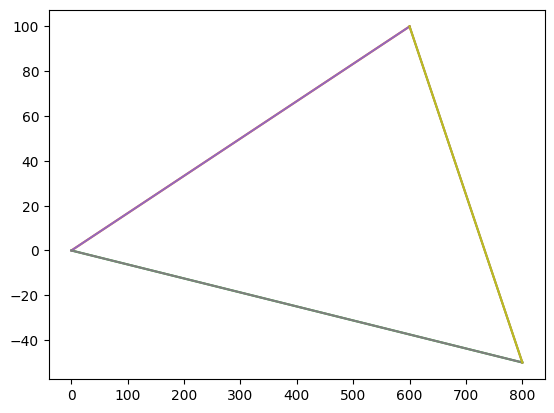

In [13]:
# initialize variables
N = 1 # number of vehicles
M = 3 # number of nodes

# initialize an adjacency matrix to define paths between the nodes

# Adj_mat = np.ones([M+1, M+1])

# Adj_mat = np.array([
#     [0, 1, 1, 0, 0, 0, 0, 1],
#     [1, 0, 1, 1, 1, 0, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1],
#     [0, 1, 0, 0, 1, 0, 0, 1],
#     [0, 1, 0, 1, 0, 1, 0, 1],
#     [0, 0, 0, 0, 1, 0, 1, 1],
#     [0, 1, 0, 0, 0, 1, 0, 1],
#     [0, 0, 0, 0, 0, 0, 0, 1]
# ])

Adj_mat = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 0, 0, 1]
])

# define the node locations
# node_lcn = np.arange(200).reshape((M, 2))
# node_lcn = 10*np.array([
#     [1, 6],
#     [3, 6],
#     [0.5, 4.5],
#     [2, 3],
#     [4, 3],
#     [2, 0],
#     [7, 3]
# ])

node_lcn = np.array([
    [0, 0],
    [600, 100],
    [800, -50]
])

# define the speed limits for every vehicle
speed_lim = np.array([
    [10, 30]
]) # [v_min, v_max] for all v

# initial and final nodes of all the uavs (dimension = N)
init_nodes = [1]
stop_nodes = [3]

# initialize annealing parameter
beta = 0.001

# create an instance of FLPO class
flpo = FLPO(N, M, Adj_mat, node_lcn, speed_lim, init_nodes, stop_nodes, beta)
print('\n -- FLPO Stages -- \n' , flpo.stages)
print('\n -- FLPO Associations -- \n' , flpo.asn_pb)
print('\n -- Cost transitions -- \n', flpo.cost_transit)
print('\n -- Minimum Transition Time Matrix -- \n' , flpo.dt_min)
print('\n -- Maximum Transition Time Matrix -- \n' , flpo.dt_max)
print(' \n -- Node Locations -- \n')
for i in flpo.node_id:
    id_i = flpo.node_id.index(i)
    plt.plot(node_lcn[id_i,0], node_lcn[id_i,1], )
    for j in flpo.node_id:
        id_j = flpo.node_id.index(j)
        if i != j and flpo.Adj_mat[id_i,id_j] == 1:
            # plot a line between i and j 
            plt.plot([node_lcn[id_i, 0], node_lcn[id_j, 0]] , [node_lcn[id_i, 1], node_lcn[id_j, 1]])


In [14]:
# initialize probability associations and time schedule parameters

x = [0, 1, 0, 0,
     0, 1, 0, 0,
     0, 0, 1, 0,
     0, 0, 0, 1,
     0, 0, 0, 1,
     0, 1, 0, 0,
     0, 0, 1, 0,
     0, 0, 0, 1,
     0, 0, 0, 1,
     1, 1, 1, 1,
     0,  20.7, 34.33]

# x = [ 1.23977755e-09,  9.19708639e-01, -2.27394867e-19,  8.02913596e-02,
#         2.72929218e-01,  3.96228147e-01, -8.85451641e-19,  3.30842634e-01,
#         2.50297802e-02,  1.64169722e-02,  9.17164186e-01,  4.13890614e-02,
#        -1.06272716e-18,  3.32955164e-01,  3.02890687e-01,  3.64154148e-01,
#         1.58143676e-16,  1.57371315e-16,  1.53497921e-16,  1.00000000e+00,
#         8.78286774e-02,  5.39818207e-01,  1.90702873e-17,  3.72353115e-01,
#         2.22873241e-01,  1.51911503e-01,  3.67549828e-01,  2.57665428e-01,
#         3.23065640e-19,  4.04776633e-02,  5.23192469e-02,  9.07203090e-01,
#         3.62346085e-16,  3.65567946e-16,  3.59849930e-16,  1.00000000e+00,
#         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
#         2.10412034e-18,  10.7, 34.33]
vec_asn_pb = flpo.flat_asn_pb(flpo.asn_pb)
# vec_schedules = [0.0, 0.7, 0.4, 1.9, 2.6, 4.5, 2.5]
vec_schedules = x[flpo.get_num_asn_pb():]
# vec_schedules = list(np.arange(100))

# vec_asn_pb = [0.20,0.47,0,0.33, 
#               0.33,0.34,0,0.33, 
#               0.25,0.25,0.25,0.25, 
#               0,0.33,0.33,0.34, 
#               0,0,0,1, 
#               0.15,0.52,0,0.33, 
#               0.25,0.25,0.25,0.25, 
#               0,0.33,0.33,0.34, 
#               0,0,0,1, 
#               1,1,1,1]
# vec_schedules = [0, 1.67, 7.05]
x0 = vec_asn_pb + vec_schedules # initial decision variables, the order of addition of lists is important
# print('initial state' , x0)

flpo.asn_pb = flpo.wrap_flat_asn_pb(vec_asn_pb)
flpo.node_param['schedules'] = flpo.wrap_flat_schedules(vec_schedules)

# free_energy = flpo.objective(x0)

# mat, lb, ub = flpo.cons_asn_pb()
# print('\n --Probability Constraints-- \n', mat)

cons = flpo.cons() # get the linear constraints
bounds = flpo.bounds() # get the bounds on decision variables

# # # cost = flpo.objective(x0)
# # D = flpo.distortion(0)
# res = minimize(
#     flpo.objective, x0, method = 'trust-constr', constraints = cons, bounds = bounds, 
#     options = {'gtol' : 1e-15 , 'initial_tr_radius' : 0.2, 
#                'factorization_method' : 'SVDFactorization' , 
#                'disp' : True, 'maxiter': 1000, 'verbose': 3}
#                )

flpo.cost_vehicle_transit(0)


In [171]:

# cost_transit_matrix = flpo.entropy_vehicle_transit(0)
# print(flpo.entropy_transit[0])
# D2, H2 = flpo.distortion(0)
# D3, H3 = flpo.calc_distortion(0)
# print('distortion and entropy looped' , D2, ' -- ', H2)
# print('distortion and entropy salar' , D3, ' -- ', H3)
# free_energy = flpo.objective(x0)
# print( '\n << Optimization result >>\n\n' , res)
# print('cost stage transition = ' , flpo.cost_stage_transit(0, 1, 3))

# # Entropy Maximization w.r.t. probability distributions
# mat, lb, ub = flpo.cons_asn_pb()
# # print('mat', mat)
# # print('lb' , lb)
# # print('ub' , ub)
# cons_asn_pb = LinearConstraint(mat, lb, ub)
# pb_lb, pb_ub = flpo.bounds_asn_pb()
# # print('pb_lb' , pb_lb, '\n pb_ub' , pb_ub)
# bounds_asn_pb =  Bounds(pb_lb, pb_ub)
# # print('objective entropy = ' , flpo.objective_entropy(vec_asn_pb))
# res = minimize(flpo.objective_entropy, vec_asn_pb, method = 'trust-constr', constraints = cons_asn_pb, bounds = bounds_asn_pb, options = {'xtol' : 1e-12 , 'gtol' : 1e-8 , 'disp' : True, 'maxiter': 5000, 'verbose': 3})
# print(res)


distortion and entropy looped 781933083.379286  --  461.51205168411286
distortion and entropy salar 781933083.3792862  --  461.5120516841263


In [29]:
# Annealing
x = [0,0.33,0.34,0.33, 
     0,0.34,0.34,0.33, 
     0.25,0,0.5,0.25, 
     0.33,0.33,0,0.34, 
     0,0,0,1, 
     0,0.34,0.33,0.33, 
     0.5,0,0.25,0.25, 
     0.33,0.33,0,0.34, 
     0,0,0,1, 
     1,1,1,1,
     0,  24.7,  35.8]
beta = 0.00001
while beta <= 10000:
    flpo.beta = beta
    # initialize probability associations and time schedule parameters

    vec_asn_pb = x[0:flpo.get_num_asn_pb()]
    vec_schedules = x[flpo.get_num_asn_pb():]

    flpo.asn_pb = flpo.wrap_flat_asn_pb(vec_asn_pb)
    flpo.node_param['schedules'] = flpo.wrap_flat_schedules(vec_schedules)

    # vec_asn_pb = flpo.flat_asn_pb(flpo.asn_pb) # initial associations
    # vec_schedules = flpo.flat_schedules(flpo.node_param['schedules']) # initial schedules

    # flpo.asn_pb = flpo.wrap_flat_asn_pb(vec_asn_pb)
    # flpo.node_param['schedules'] = flpo.wrap_flat_schedules(vec_schedules)

    x0 = vec_asn_pb + vec_schedules # initial decision variables, the order of addition of lists is important
    # print('initial state' , x0)

    mat, lb, ub = flpo.cons_asn_pb()
    # print('\n --Probability Constraints-- \n', mat)

    cons = flpo.cons() # get the linear constraints
    bounds = flpo.bounds() # get the bounds on decision variables

    # cost = flpo.objective(x0)
    # print('cost = ' , cost)
    res = minimize(
        flpo.objective, x0, method = 'trust-constr', constraints = cons, bounds = bounds, 
        options = {'gtol' : 1e-15 , 
                   'factorization_method' : 'SVDFactorization' , 
                   'disp' : True, 'maxiter': 20000, 'verbose': 0}
                )
    
    x = list(res['x'])
    print(' ---------------------------------------- ')
    print('Optimization result for beta = ' , flpo.beta, '\n' , ' cost = ' , res['fun'],  'sol = ' , res['x'])

    beta = 10*beta
    

The maximum number of function evaluations is exceeded.
Number of iterations: 20000, function evaluations: 880000, CG iterations: 26659, optimality: 6.56e+00, constraint violation: 1.10e-09, execution time: 2.1e+02 s.
 ---------------------------------------- 
Optimization result for beta =  1e-05 
  cost =  -270640.26856908697 sol =  [ 2.12921311e-10  4.66835645e-01  4.66387614e-01  6.67767410e-02
  1.63071262e-10  3.39407646e-01  3.32783043e-01  3.27809311e-01
  4.28518828e-01  1.85563016e-10  4.28440053e-01  1.43041118e-01
  4.27503712e-01  4.29317767e-01 -1.06965717e-09  1.43178523e-01
 -1.54141716e-11 -1.94665628e-11 -4.38458059e-11  1.00000000e+00
 -1.02097840e-10  3.33334030e-01  3.33333064e-01  3.33332906e-01
  3.33020395e-01 -1.32190632e-10  3.33490478e-01  3.33489128e-01
  3.32285573e-01  3.33849865e-01 -1.49060644e-10  3.33864562e-01
 -1.32081985e-11  5.30339597e-12 -2.73608941e-12  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.78688955e

In [24]:

sol = [ 9.54811212e-09,  4.68303809e-01,  4.64350667e-01,  6.73455217e-02,
 -6.33656551e-08,  3.21867549e-01,  3.19559565e-01,  3.58572984e-01,
  4.25427185e-01,  5.80463004e-08,  4.30321441e-01,  1.44251298e-01,
  4.16639725e-01,  4.36948490e-01, -3.26099075e-08,  1.46411863e-01,
  5.59228092e-08, -1.08678149e-08, -2.75307003e-08,  9.99999979e-01,
  1.69699758e-08,  3.39335524e-01,  3.25464886e-01,  3.35199552e-01,
  3.28534158e-01,  3.18426069e-08,  3.38400047e-01,  3.33065727e-01,
  3.20789207e-01,  3.43309027e-01, -5.70769332e-08,  3.35901885e-01,
  4.59613304e-08, -1.57680455e-07,  9.89092295e-08,  1.00000002e+00,
  1.00000005e+00,  9.99999992e-01,  9.99999971e-01,  9.99999971e-01,
  1.64618053e-09,  2.15868707e+01,  2.83517762e+01]
# print(sol)
vec_asn_pb = sol[0:flpo.get_num_asn_pb()]
print(vec_asn_pb)
flpo.asn_pb = flpo.wrap_flat_asn_pb(vec_asn_pb)
p0 = flpo.asn_pb[0][0][0,2]
p1 = flpo.asn_pb[0][1][2,1]
p2 = flpo.asn_pb[0][2][1,3]
p3 = flpo.asn_pb[0][3][3,0]

print('\n')

print('p0 = ' , p0)
print('p1 = ' , p1)
print('p2 = ' , p2)
print('p3 = ' , p3)

print('\n path probability = ' , p0*p1*p2*p3)

[9.54811212e-09, 0.468303809, 0.464350667, 0.0673455217, -6.33656551e-08, 0.321867549, 0.319559565, 0.358572984, 0.425427185, 5.80463004e-08, 0.430321441, 0.144251298, 0.416639725, 0.43694849, -3.26099075e-08, 0.146411863, 5.59228092e-08, -1.08678149e-08, -2.75307003e-08, 0.999999979, 1.69699758e-08, 0.339335524, 0.325464886, 0.335199552, 0.328534158, 3.18426069e-08, 0.338400047, 0.333065727, 0.320789207, 0.343309027, -5.70769332e-08, 0.335901885, 4.59613304e-08, -1.57680455e-07, 9.89092295e-08, 1.00000002, 1.00000005, 0.999999992, 0.999999971, 0.999999971]


p0 =  0.464350667
p1 =  0.43694849
p2 =  0.333065727
p3 =  0.999999971

 path probability =  0.06757814235702349


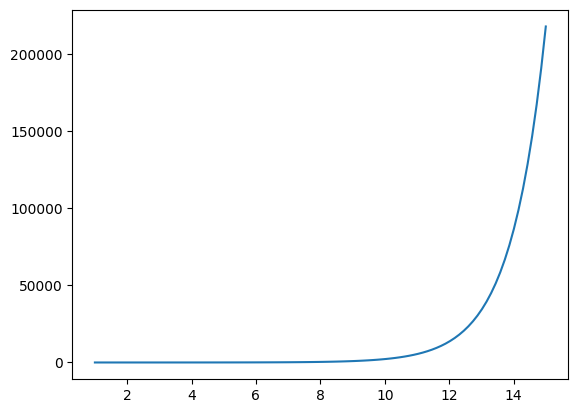

In [7]:
#Test block for penalty function

x = np.linspace(-5, 15, 100)
# print(x)
a = 2
b = 2
A = 100
xmin = 5
xmax = 10
# fx = x + np.exp(a*(xmin - x)) + np.exp(b*(x - xmax))
# fx = x - np.log(a*(x - 1)) - np.log(b*(3 - x))
# fx = x + 1/(x-1) + 1/(2 - x)
# fx = -np.log(x)
# fx = x + A*np.exp(a*(x-2)**2) / (np.exp(a*(x-2)**2) + np.exp(-b*(x-2)**2)) - A/2
# fx = x + (np.tanh(a*(x-xmax))+ np.tanh(b*(xmin-x)) + 2)*A
# fx = x + A * np.tanh((xmin - x)**2) 
# fx = x + (np.maximum(0, (x-xmin)*(x-xmax)))**2
# fx = x + 1/A * np.log( 1 + np.exp(A*(x-xmin)*(x-xmax)))
fx = 1/np.cosh(x)**2 #np.exp(x)/(np.exp(x)+np.exp(-x))

plt.figure(1)
plt.plot(x, fx)
# plt.plot(x, x)
plt.show()
# print(res)

In [17]:
# test block for vectorization

def func(u, v, w):
    return u+v+w

vec_func = np.vectorize(func)
u = np.array([1,2,3])
v = np.array([[2,3,4],[3,5,6]])
w = np.array([4,5,6])
out = vec_func(u,v,w)
print(out)

[[ 7 10 13]
 [ 8 12 15]]
